In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import bernoulli
import math

In [2]:
file = open("CTR.txt", "r")
description = {}
click_rates = {}
#Repeat for each song in the text file
i = 0
for line in file.readlines():
    #Let's split the line into an array called "fields" using the ";" or ":" as a separator
    fields = re.split(';|:',line[:-1])
    # description of the articles
    description[int(fields[0])] = np.array([float(desc) for desc in fields[1:6]])
    # click rates associated with this article
    click_rates[int(fields[0])] = np.array([float(rate) for rate in fields[6:len(fields)+1]])
file.close()

# we store both the description of an article and the click rates associated with it in one dictionnary
data = {"description" : description, "click_rates" : click_rates}

In [3]:
class Strategy:
    def __init__(self, nb_arms):
        self.nb_arms = nb_arms
        self.mu = np.zeros(self.nb_arms)
        self.times = np.zeros(self.nb_arms)
    def action(self, data, time):
        pass
    def update(self, action, data, time):
        self.mu[action] +=  data["click_rates"][time][action]
        self.times[action] += 1
    def return_mu_hat(self):
        return (self.mu, self.times)

In [4]:
class Environement:
    def __init__(self, data, T):
        self.data = data
        self.T = T
    def evaluate(self, strategy):
        rewards = np.zeros(self.T)
        for time_step in range(self.T):
            action = strategy.action(self.data, time_step)
            rewards[time_step] = self.data["click_rates"][time_step][action]
        return rewards

In [5]:
class Random(Strategy):
    def __init__(slef,nb_arms):
        super().__init__(nb_arms)
    def action(self, data, time):
        action = np.random.randint(self.nb_arms)
        self.update(action, data, time)
        return action

In [6]:
class StaticBest(Strategy):
    def __init__(self, nb_arms, pre):
        super().__init__(nb_arms)
        # numbre of preliminary iterations
        self.pre = pre
            
    def action(self, data, time):
        if (time >= self.pre) :
            action = np.argmax(self.mu/self.times)
        else :
            action = np.random.randint(self.nb_arms)
        self.update(action, data, time)
        return action

In [7]:
class EpsilonGreedy(Strategy):
    def __init__(self, nb_arms, pre, epsilon):
        super().__init__(nb_arms)
        # with probability epsilon we explore
        self.epsilon = epsilon
        self.pre = pre
            
    def action(self, data, time):
        if (time < self.pre) :
            action = np.random.randint(self.nb_arms)
        elif bernoulli.rvs(self.epsilon):
            action = np.random.randint(self.nb_arms)
        else :
            action = np.argmax(self.mu/self.times)
        self.update(action, data, time)
        return action

In [8]:
class Optimal(Strategy):
    def __init__(self, nb_arms):
        super().__init__(nb_arms)
    def action(self, data, time):
        action = np.argmax(data["click_rates"][time])
        self.update(action, data, time)
        return action
    

In [57]:
class UCB(Strategy):
    def __init__(self, nb_arms, pre):
        super().__init__(nb_arms)
        # number of preliminary iterations
        self.pre = pre
            
    def action(self, data, time):
        if (time > self.pre) :
            action = np.argmax(self.mu/self.times + 0.5*np.sqrt((2*math.log(time)) / self.times))
        else :
            action = np.random.randint(self.nb_arms)
        self.update(action, data, time)
        return action

In [58]:
class LinUCB(Strategy):
    def __init__(self, nb_arms, pre):
        super().__init__(nb_arms)
        # numbre of preliminary iterations
        self.pre = pre
        self.A = {}
        self.B = {}
            
    def action(self, data, time):
        if (time > self.pre) :
            p = np.zeros(self.nb_arms)
            for a in range(self.nb_arms):
                if a not in self.A.keys():
                    self.A[a] = np.identity(len(data["description"][time]))
                    self.B[a] = np.zeros(len(data["description"][time]))
                mu_hat_a = np.linalg.inv(self.A[a]) @ self.B[a]
                p_a = mu_hat_a.T @ data["description"][time] + alpha \
                * np.sqrt(data["description"][time] @ np.linalg.inv(self.A[a]) @ data["description"][time])
                p[a] = p_a
            action = np.argmax(p)
            self.A[action] = self.A[action] + (data["description"][time] @ data["description"][time])
            self.B[action] = self.B[action] + (data["click_rates"][time][action] * data["description"][time])
        else :
            action = np.random.randint(self.nb_arms)
        self.update(action, data, time)
        return action

In [59]:
#Global variables
T = len(data["description"])
nb_actions = len(data["click_rates"][0])
pre_ucb = 50
pre_lin_ucb = 50
pre_static_best = 50
pre_epsilon_greedy = 50
epsilon = 0.3
alpha = 1 + math.sqrt(math.log(2 / 0.2) / 2)
print("T : ",T," | Nb actions : ",nb_actions," | alpha : ",alpha)
print("| Nb Preliminary : ")
print("\n \t For static best : ",pre_static_best)
print("\n \t For epsilon greedy : ",pre_epsilon_greedy," with epsilon = ",epsilon)
print("\n \t For ucb : ",pre_ucb)
print("\n \t For lin_ucb : ",pre_lin_ucb)

T :  5000  | Nb actions :  10  | alpha :  2.0729830131446736
| Nb Preliminary : 

 	 For static best :  50

 	 For epsilon greedy :  50  with epsilon =  0.3

 	 For ucb :  50

 	 For lin_ucb :  50


/home/chekirou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/chekirou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


Text(0.5, 1.0, 'gains cumulés')

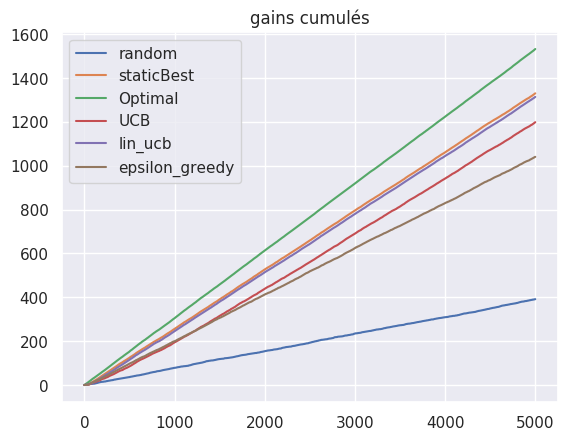

In [60]:
evironement = Environement(data, T)

# define the strategies
random_strategy = Random(nb_actions)
staticbest_strategy = StaticBest(nb_actions, pre_static_best)
optimal_strategy = Optimal(nb_actions)
ucb_strategy = UCB(nb_actions, pre_ucb)
lin_ucb_strategy = LinUCB(nb_actions, pre_lin_ucb)
epsilon_greedy_strategy = EpsilonGreedy(nb_actions, pre_epsilon_greedy, epsilon)

# evaluation of each strategy
random = evironement.evaluate(random_strategy)
static_best = evironement.evaluate(staticbest_strategy)
optimal = evironement.evaluate(optimal_strategy)
ucb = evironement.evaluate(ucb_strategy)
lin_ucb = evironement.evaluate(lin_ucb_strategy)
epsilon_greedy = evironement.evaluate(epsilon_greedy_strategy)

#plot the curves
time_axis = np.arange(T)
plt.plot(time_axis, np.cumsum(random), label="random")
plt.plot(time_axis, np.cumsum(static_best), label="staticBest")
plt.plot(time_axis, np.cumsum(optimal), label="Optimal")
plt.plot(time_axis, np.cumsum(ucb), label="UCB")
plt.plot(time_axis, np.cumsum(lin_ucb), label="lin_ucb")
plt.plot(time_axis, np.cumsum(epsilon_greedy), label="epsilon_greedy")
plt.legend(loc="upper left")
plt.title("gains cumulés")

Text(0, 0.5, 'Regrets')

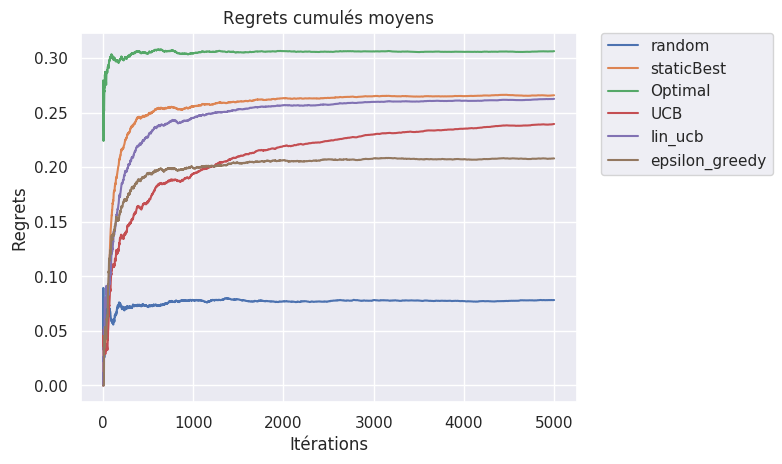

In [64]:
#plot the curves
import seaborn as sns

plt.rcdefaults()
sns.set()
time_axis = np.arange(1,T+1)
plt.plot(time_axis, np.cumsum(random)/time_axis, label="random")
plt.plot(time_axis, np.cumsum(static_best)/time_axis, label="staticBest")
plt.plot(time_axis, np.cumsum(optimal)/time_axis, label="Optimal")
plt.plot(time_axis, np.cumsum(ucb)/time_axis, label="UCB")
plt.plot(time_axis, np.cumsum(lin_ucb)/time_axis, label="lin_ucb")
plt.plot(time_axis, np.cumsum(epsilon_greedy)/time_axis, label="epsilon_greedy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Regrets cumulés moyens")
plt.xlabel("Itérations")
plt.ylabel("Regrets")

Text(0, 0.5, 'Gains')

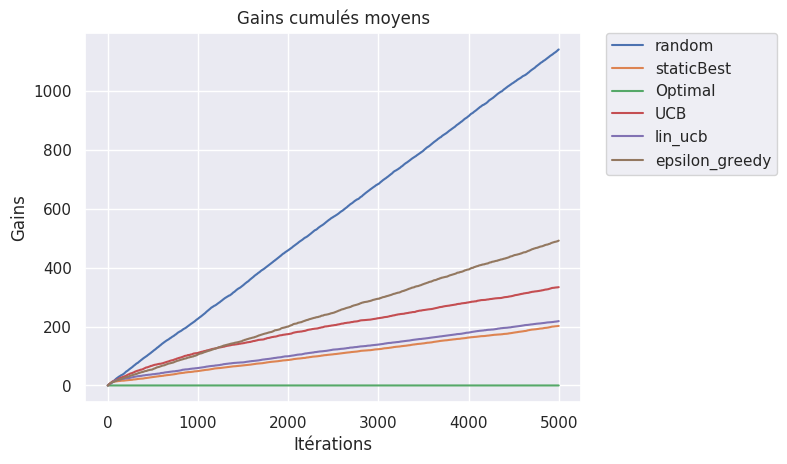

In [62]:
#plot the curves of regret
time_axis = np.arange(T)
plt.plot(time_axis, np.cumsum(optimal) - np.cumsum(random), label="random")
plt.plot(time_axis, np.cumsum(optimal) - np.cumsum(static_best), label="staticBest")
plt.plot(time_axis, np.cumsum(optimal) - np.cumsum(optimal), label="Optimal")
plt.plot(time_axis, np.cumsum(optimal) - np.cumsum(ucb), label="UCB")
plt.plot(time_axis, np.cumsum(optimal) - np.cumsum(lin_ucb), label="lin_ucb")
plt.plot(time_axis, np.cumsum(optimal) - np.cumsum(epsilon_greedy), label="epsilon_greedy")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Gains cumulés moyens")
plt.xlabel("Itérations")
plt.ylabel("Gains")

Text(0, 0.5, 'Gains')

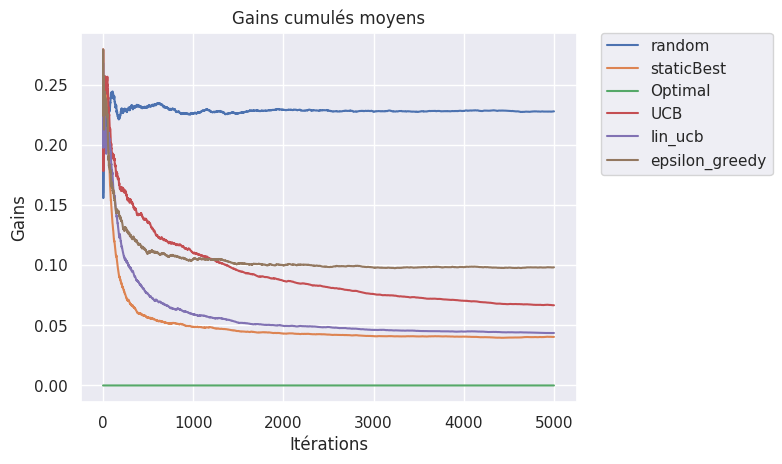

In [63]:
plt.rcdefaults()
sns.set()
time_axis = np.arange(1, T+1)
plt.plot(time_axis, (np.cumsum(optimal) - np.cumsum(random))/time_axis, label="random")
plt.plot(time_axis, (np.cumsum(optimal) - np.cumsum(static_best))/time_axis, label="staticBest")
plt.plot(time_axis, (np.cumsum(optimal) - np.cumsum(optimal)) /time_axis, label="Optimal")
plt.plot(time_axis, (np.cumsum(optimal) - np.cumsum(ucb))/time_axis, label="UCB")
plt.plot(time_axis, (np.cumsum(optimal) - np.cumsum(lin_ucb))/time_axis, label="lin_ucb")
plt.plot(time_axis, (np.cumsum(optimal) - np.cumsum(epsilon_greedy))/time_axis, label="epsilon_greedy")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Gains cumulés moyens")
plt.xlabel("Itérations")
plt.ylabel("Gains")